In [1]:

from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

import glob


In [2]:
# Copy and modify the ParallaxMetric

class BDParallaxMetric(BaseMetric):
    """Calculate the distance to which one could reach a parallax SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
    distances : np.array
        Distances to try putting the object at (pc).
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='bdParallax', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 badval=0, mags={'z': 18.18, 'y': 17.13}, parallax_snr=10.,
                 distances=np.arange(10, 200, 20), 
                 atm_err=0.01, normalize=False, min_exp_time=15., 
                 exptimeCol='visitExposureTime', **kwargs):
        Cols = [m5Col, filterCol, seeingCol, exptimeCol, 'ra_pi_amp', 'dec_pi_amp']
        
        units = 'pc'
        super(BDParallaxMetric, self).__init__(Cols, metricName=metricName, units=units,
                                             badval=badval, **kwargs)
        # set return type
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.distances = distances
        self.exptimeCol = exptimeCol
        self.mags = {}
        distance_mod = 5.0*np.log10(distances)-5.0
        for key in mags:
            self.mags[key] = mags[key] + distance_mod
        self.parallax_snr_goal = parallax_snr
        self.atm_err = atm_err
        self.filters = list(self.mags.keys())
        self.parallaxes = 1000.0/distances  #mas
        self.min_exp_time = min_exp_time
        
    def _final_sigma(self, position_errors, ra_pi_amp, dec_pi_amp):
        """Assume parallax in RA and DEC are fit independently, then combined.
        All inputs assumed to be arcsec """
        sigma_A = position_errors/ra_pi_amp
        sigma_B = position_errors/dec_pi_amp
        sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
        sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
        # Combine RA and Dec uncertainties, convert to mas
        sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3
        return sigma

    def run(self, dataslice, slicePoint=None):
        snr = np.zeros((np.size(self.mags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            if self.min_exp_time is not None:
                good = np.where((dataslice[self.filterCol] == filt) &
                                (dataslice[self.exptimeCol] >= self.min_exp_time))[0]
            else:
                good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                snr[:, good] = mafUtils.m52snr(self.mags[str(filt)][:, np.newaxis],
                                               dataslice[self.m5Col][good])
                
        
        position_errors = np.sqrt(mafUtils.astrom_precision(dataslice[self.seeingCol],
                                                            snr)**2+self.atm_err**2)
        # uncertainty in the parallax in mas
        sigma = self._final_sigma(position_errors, dataslice['ra_pi_amp'], dataslice['dec_pi_amp'])
        fitted_parallax_snr = self.parallaxes/sigma
        result = self.badval
        # Let's interpolate to the distance where we would get our target SNR
        if np.max(fitted_parallax_snr) >= self.parallax_snr_goal:
            f = interpolate.interp1d(fitted_parallax_snr, self.distances, fill_value="extrapolate")
            result = f(self.parallax_snr_goal)
        return result

In [3]:
class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2230504 visits
Running:  ['_sims_maf_fbs_1_5_rolling_rolling_mod2_sdf_0_10_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9655  dipole: lon: 128.483, lat: -82.1698, amp: 17.1921
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2229669 visits
Running:  ['_sims_maf_fbs_1_5_rolling_rolling_mod2_sdf_0_20_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9331  dipole: lon: 129.181, lat: -81.7005, amp: 16.9224
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2232716 visits
Running:  ['_sims_maf_fbs_1_5_rolling_rolling_mod3_sdf_0_10_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.7141  dipole: lon: 129.225, lat: -83.0284, amp: 16.3703
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2232606 visits
Running:  ['_sims_maf_fbs_1_5_rolling_rolling_mod3_sdf_0_20_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.7236  dipole: lon: 127.833, lat: -82.5192, amp: 16.413
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2237908 visits
Running:  ['_sims_maf_fbs_1_5_rolling_rolling_mod6_sdf_0_10_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.6222  dipole: lon: 135.288, lat: -84.4319, amp: 15.2391
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2236481 visits
Running:  ['_sims_maf_fbs_1_5_rolling_rolling_mod6_sdf_0_20_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.6234  dipole: lon: 133.578, lat: -84.0727, amp: 15.5491
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2310613 visits
Running:  ['_sims_maf_fbs_1_5_same_filt_baseline_samefilt_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.8897  dipole: lon: 125.54, lat: -84.4047, amp: 19.538
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2536392 visits
Running:  ['_sims_maf_fbs_1_5_short_exp_short_exp_2ns_1expt_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.7219  dipole: lon: 117.372, lat: -80.7329, amp: 17.8451
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2499195 visits
Running:  ['_sims_maf_fbs_1_5_short_exp_short_exp_2ns_5expt_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.6484  dipole: lon: 117.827, lat: -80.814, amp: 17.7123
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2905483 visits
Running:  ['_sims_maf_fbs_1_5_short_exp_short_exp_5ns_1expt_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.4106  dipole: lon: 119.644, lat: -81.0677, amp: 17.8897
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2821221 visits
Running:  ['_sims_maf_fbs_1_5_short_exp_short_exp_5ns_5expt_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.781  dipole: lon: 122.598, lat: -81.3926, amp: 18.3154
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2228766 visits
Running:  ['_sims_maf_fbs_1_5_spiders_spiders_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9593  dipole: lon: 121.64, lat: -81.8933, amp: 18.5703
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2240627 visits
Running:  ['_sims_maf_fbs_1_5_third_obs_third_obs_pt120v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.4018  dipole: lon: 121.921, lat: -82.539, amp: 19.0721
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2224095 visits
Running:  ['_sims_maf_fbs_1_5_third_obs_third_obs_pt15v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9513  dipole: lon: 121.825, lat: -82.2703, amp: 18.5573
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2224730 visits
Running:  ['_sims_maf_fbs_1_5_third_obs_third_obs_pt30v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9126  dipole: lon: 120.854, lat: -81.7243, amp: 18.5854
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2225855 visits
Running:  ['_sims_maf_fbs_1_5_third_obs_third_obs_pt45v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.8776  dipole: lon: 121.787, lat: -82.1833, amp: 18.6697
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2228508 visits
Running:  ['_sims_maf_fbs_1_5_third_obs_third_obs_pt60v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.7629  dipole: lon: 119.809, lat: -82.2777, amp: 18.6506
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2235263 visits
Running:  ['_sims_maf_fbs_1_5_third_obs_third_obs_pt90v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.7235  dipole: lon: 122.754, lat: -82.6644, amp: 18.6558
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 3174604 visits
Running:  ['_sims_maf_fbs_1_5_twilight_neo_twilight_neo_mod1_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.7032  dipole: lon: 135.221, lat: -81.148, amp: 22.2719
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2701354 visits
Running:  ['_sims_maf_fbs_1_5_twilight_neo_twilight_neo_mod2_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 51.9044  dipole: lon: 125.051, lat: -85.6153, amp: 23.9165
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2545115 visits
Running:  ['_sims_maf_fbs_1_5_twilight_neo_twilight_neo_mod3_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.4053  dipole: lon: 129.406, lat: -84.7745, amp: 22.8811
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2461737 visits
Running:  ['_sims_maf_fbs_1_5_twilight_neo_twilight_neo_mod4_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.9601  dipole: lon: 125.506, lat: -84.3226, amp: 21.8711
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2094827 visits
Running:  ['_sims_maf_fbs_1_5_u60_u60_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.7442  dipole: lon: 120.97, lat: -81.8832, amp: 18.0483
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2099047 visits
Running:  ['_sims_maf_fbs_1_5_var_expt_var_expt_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 55.9713  dipole: lon: 118.531, lat: -84.1345, amp: 16.2785
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2227379 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_65_noddf_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 58.1768  dipole: lon: 129.573, lat: -79.427, amp: 13.6237
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2225715 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_65_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 212 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 57.4746  dipole: lon: 123.858, lat: -79.8565, amp: 13.7329
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2227429 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_70_noddf_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 57.9806  dipole: lon: 122.116, lat: -78.7628, amp: 14.0014
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2225426 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_70_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 57.2475  dipole: lon: 119.439, lat: -79.0984, amp: 14.204
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2226780 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_75_noddf_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 57.7514  dipole: lon: 118.971, lat: -78.3823, amp: 14.4594
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2225234 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_75_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 57.0471  dipole: lon: 116.889, lat: -78.7486, amp: 14.6968
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2226618 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_80_noddf_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 57.3753  dipole: lon: 115.896, lat: -77.8617, amp: 14.9765
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2225371 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_80_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 56.8231  dipole: lon: 114.526, lat: -78.4136, amp: 14.9344
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2226787 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_85_noddf_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 56.9149  dipole: lon: 114.591, lat: -78.1115, amp: 15.8113
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2224765 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_85_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 56.3132  dipole: lon: 113.387, lat: -78.7288, amp: 15.7724
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2225486 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_90_noddf_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 55.5361  dipole: lon: 119.097, lat: -81.6359, amp: 18.2191
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2224196 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_90_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9676  dipole: lon: 122.761, lat: -82.2357, amp: 18.387
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2225655 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_95_noddf_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.1871  dipole: lon: 134.872, lat: -85.6962, amp: 22.0335
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2224239 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_95_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.7744  dipole: lon: 137.411, lat: -86.1418, amp: 21.7338
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2226029 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_99_noddf_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.149  dipole: lon: 127.466, lat: -84.6386, amp: 21.473
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'observationStartMJD'].
Found 2224332 visits
Running:  ['_sims_maf_fbs_1_5_wfd_depth_wfd_depth_scale0_99_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.7105  dipole: lon: 129.276, lat: -84.7564, amp: 21.3651
  mono, lon, lat, amp


Plotting complete.


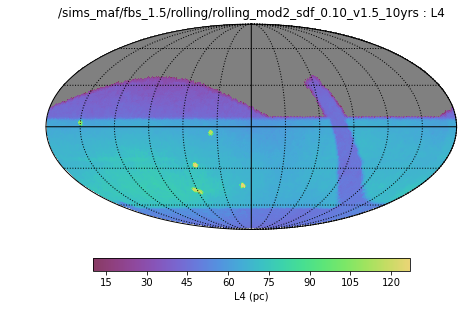

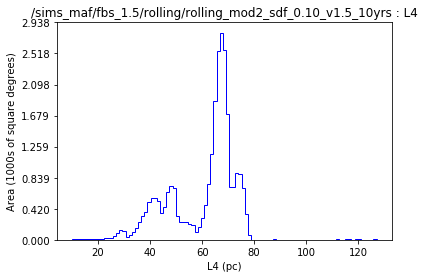

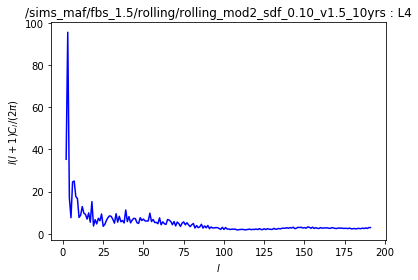

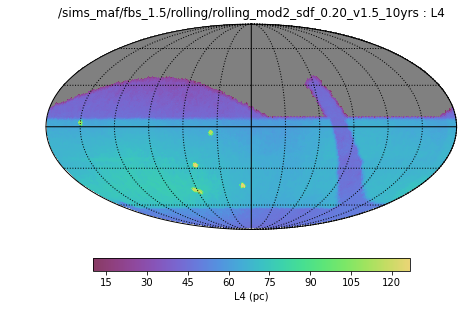

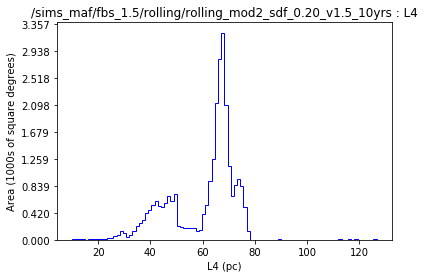

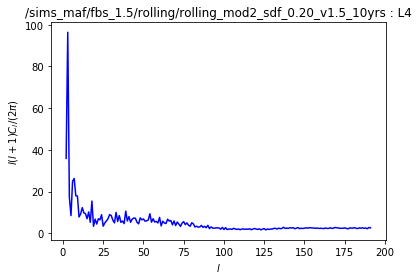

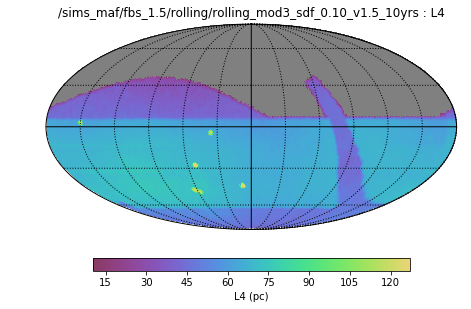

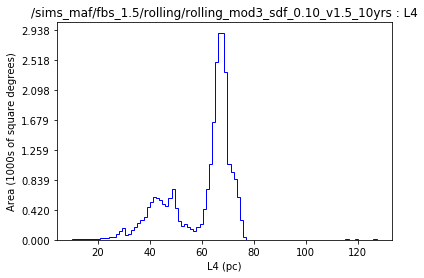

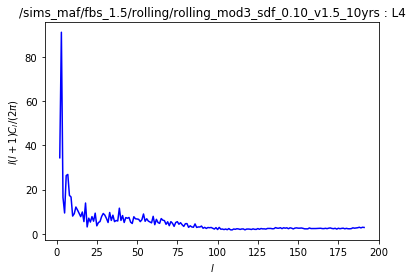

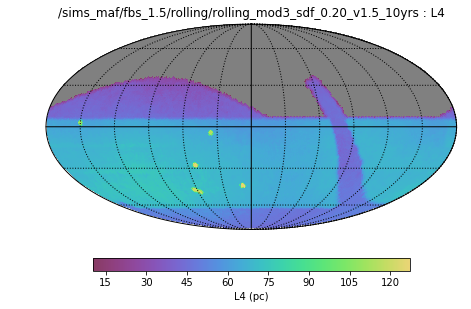

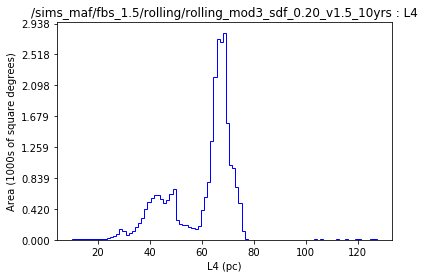

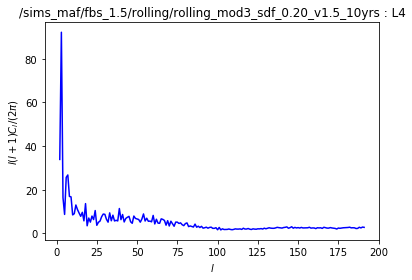

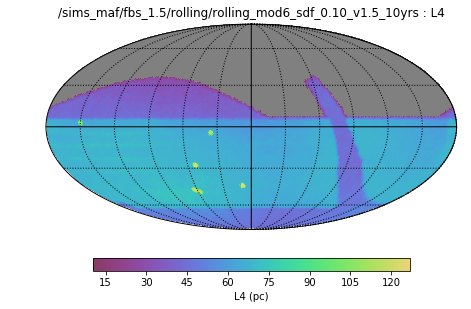

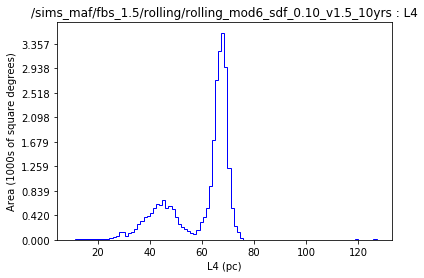

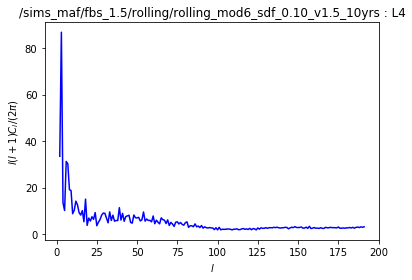

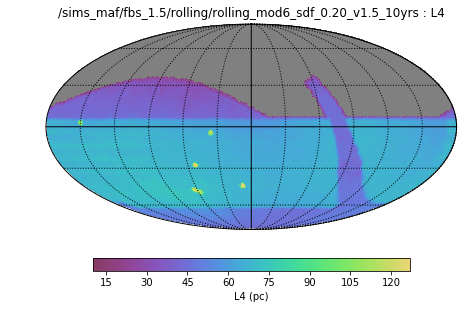

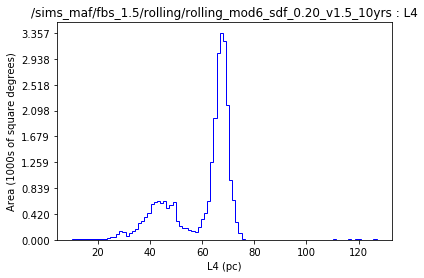

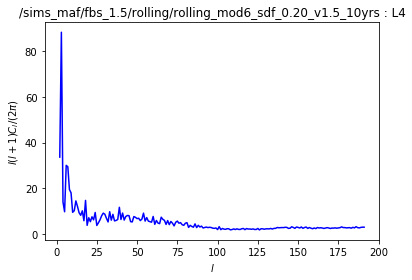

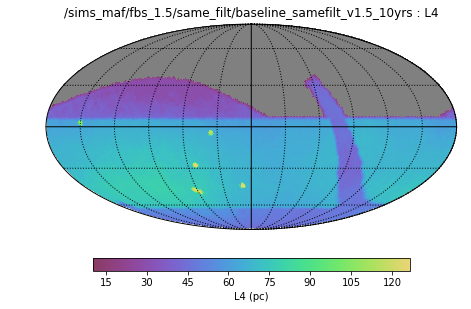

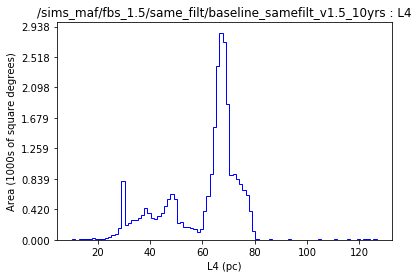

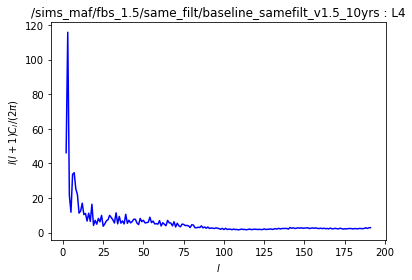

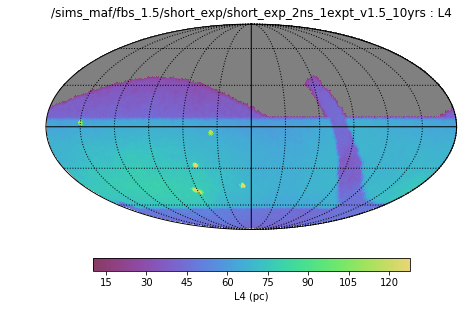

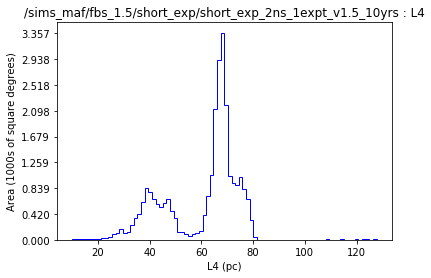

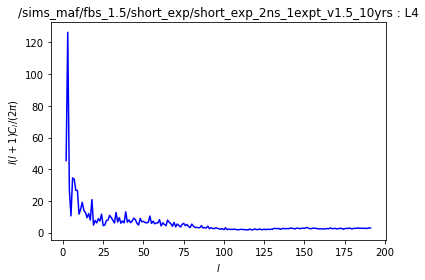

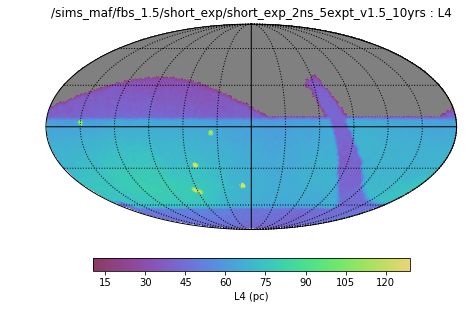

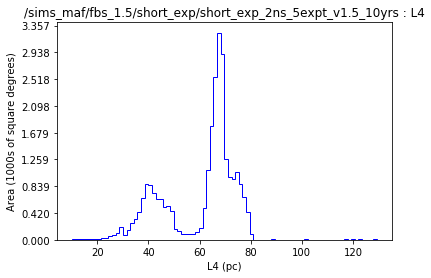

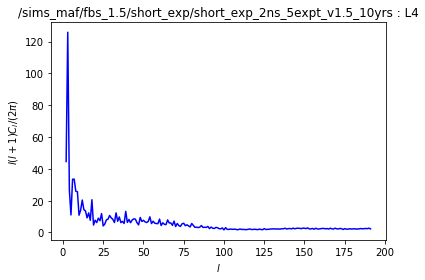

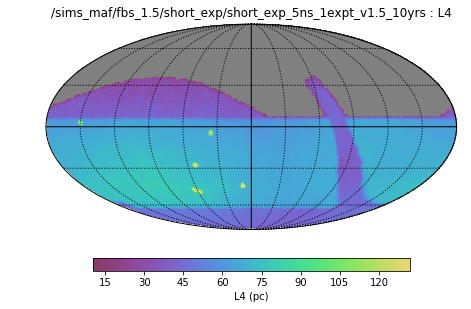

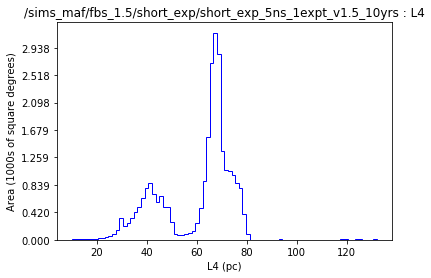

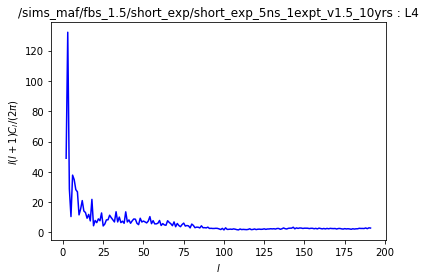

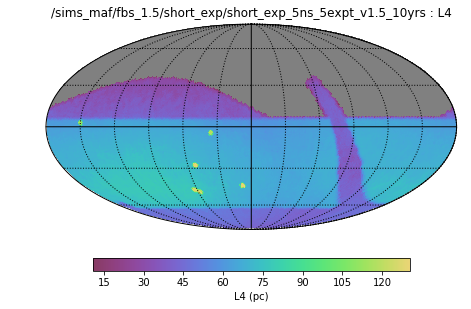

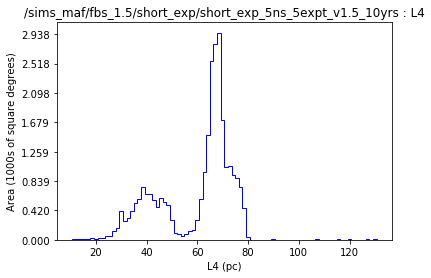

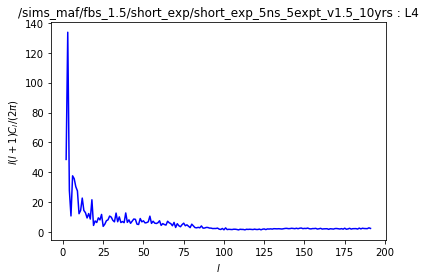

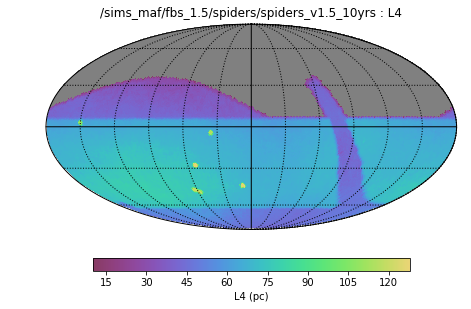

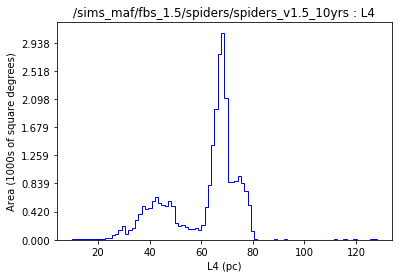

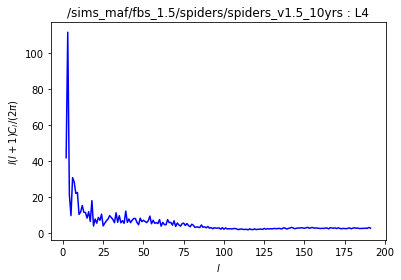

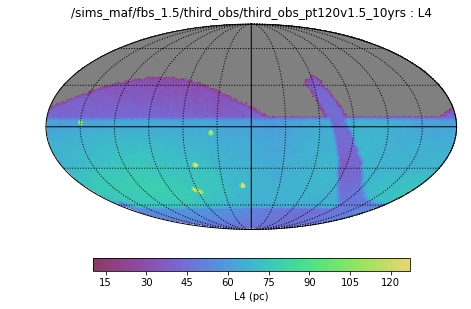

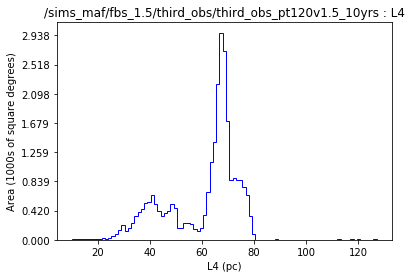

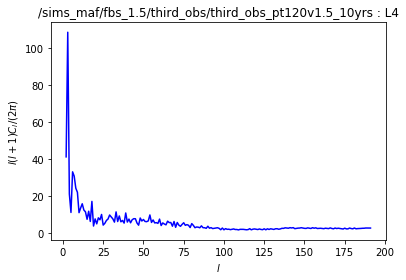

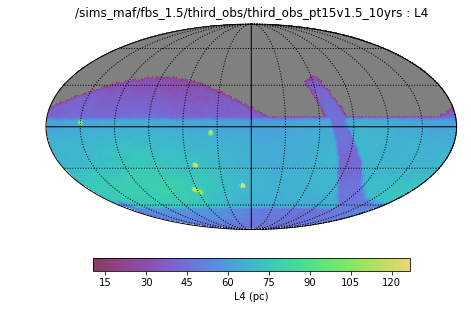

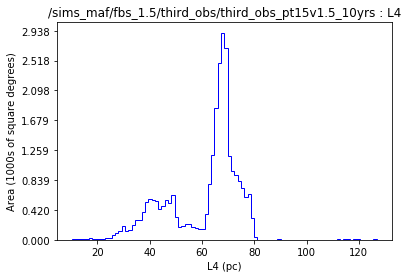

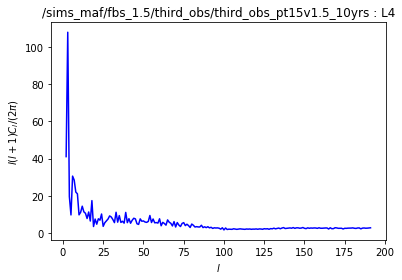

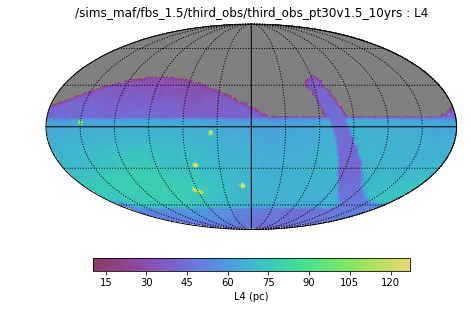

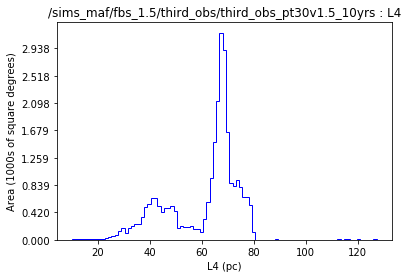

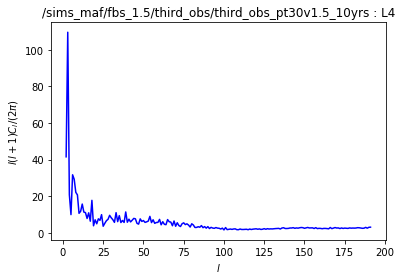

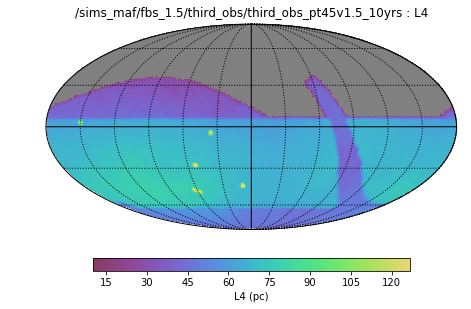

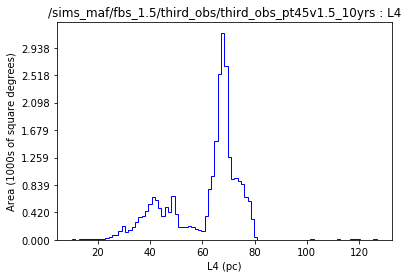

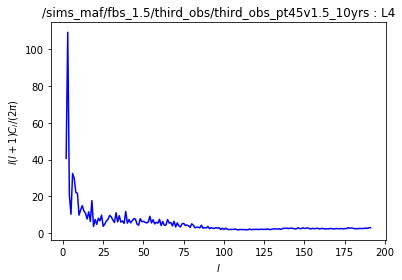

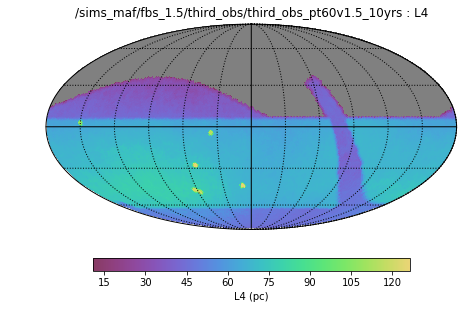

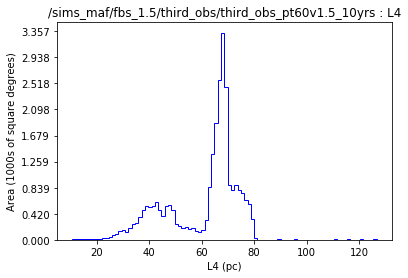

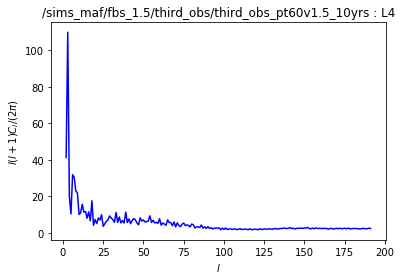

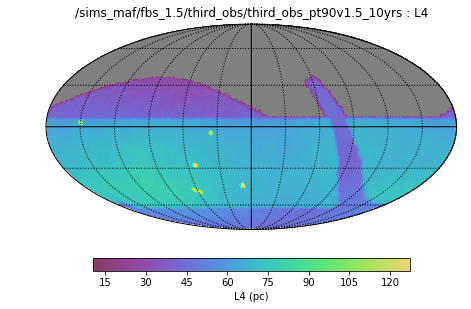

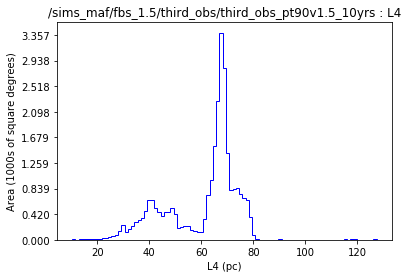

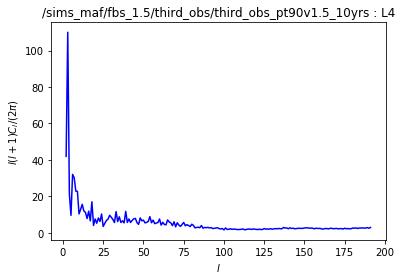

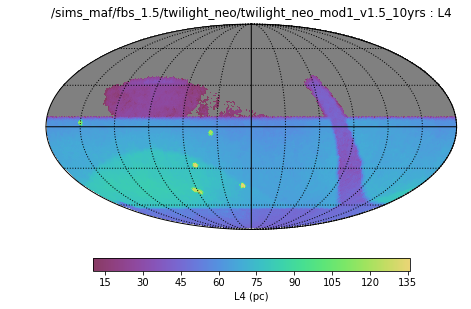

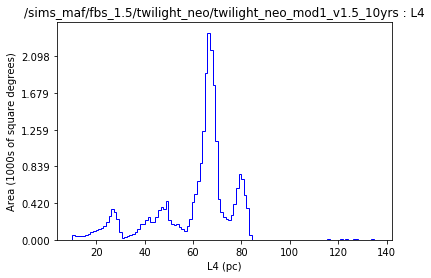

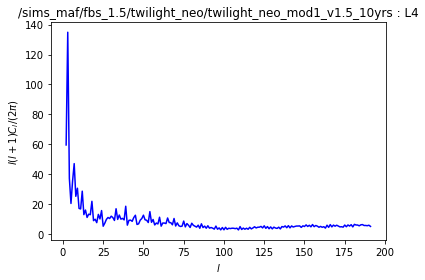

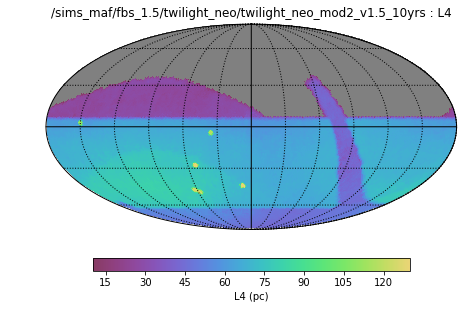

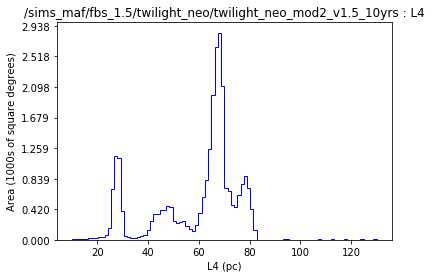

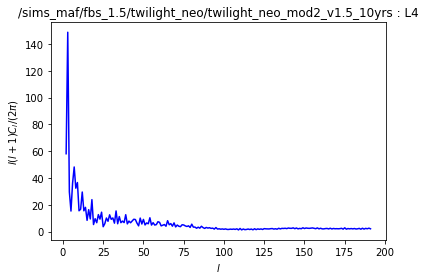

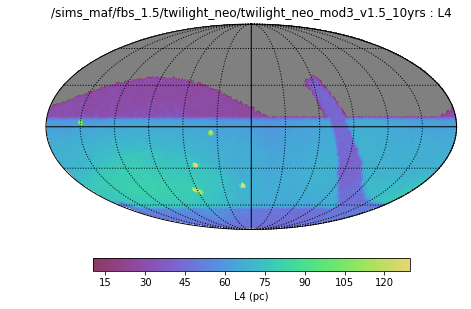

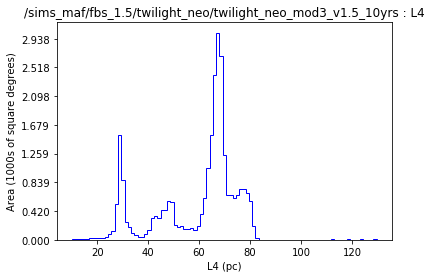

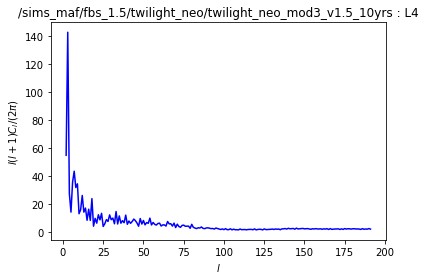

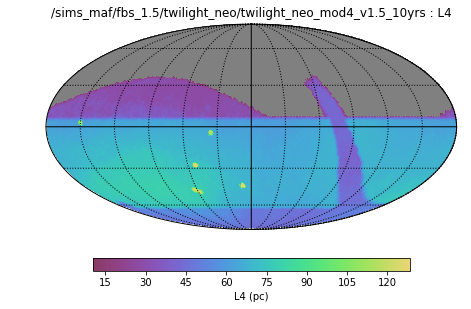

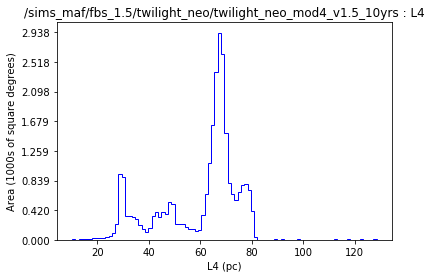

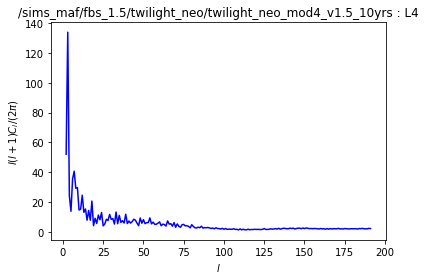

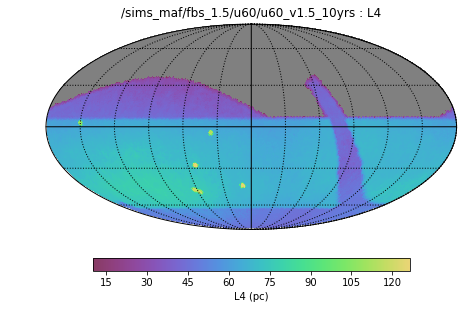

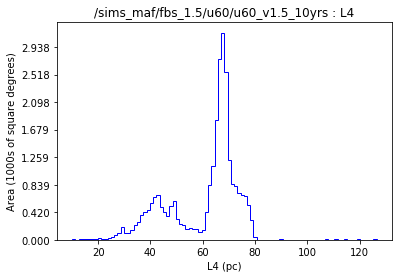

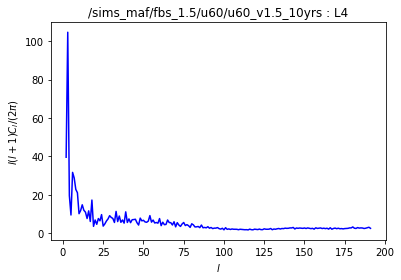

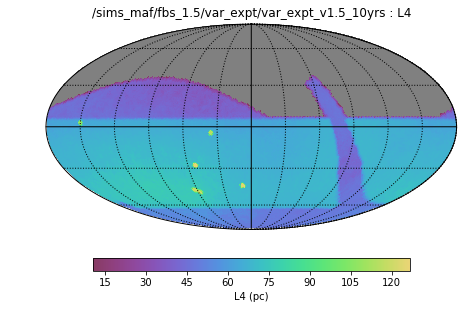

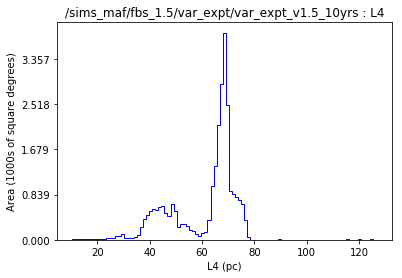

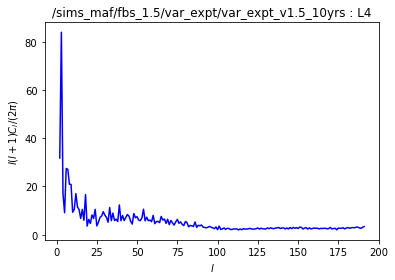

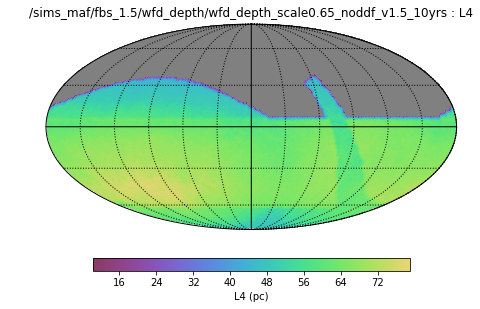

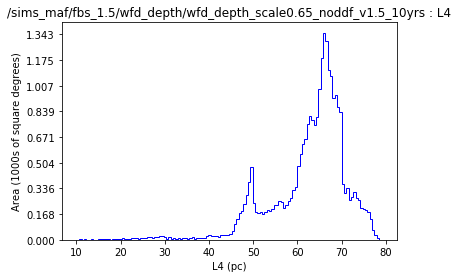

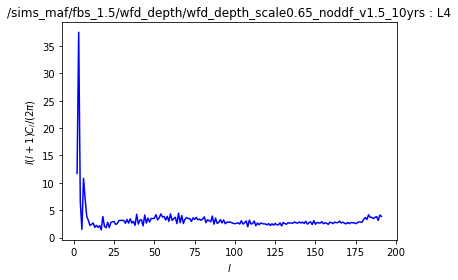

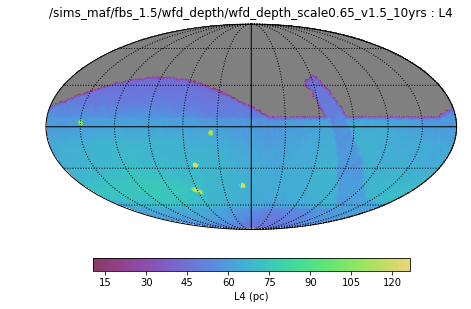

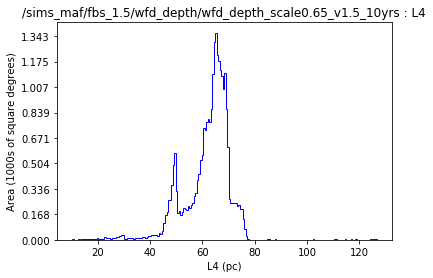

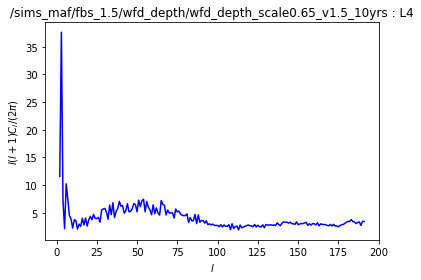

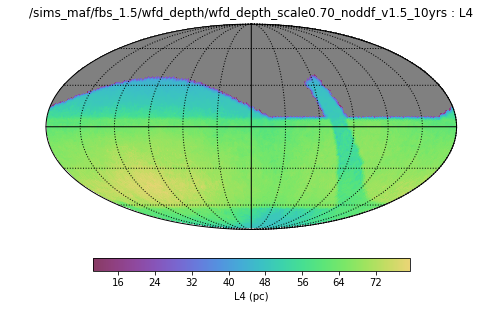

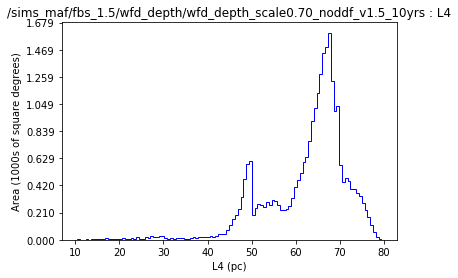

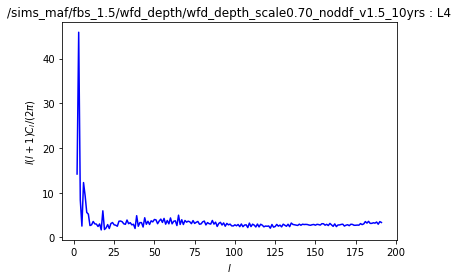

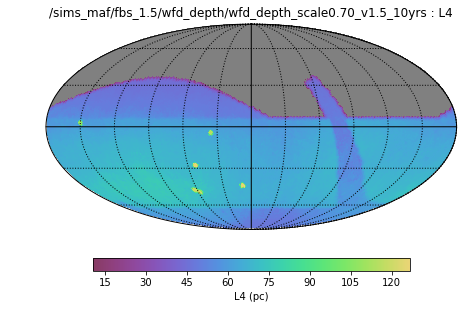

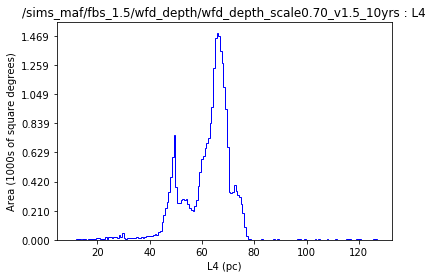

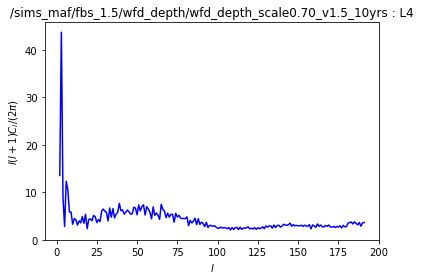

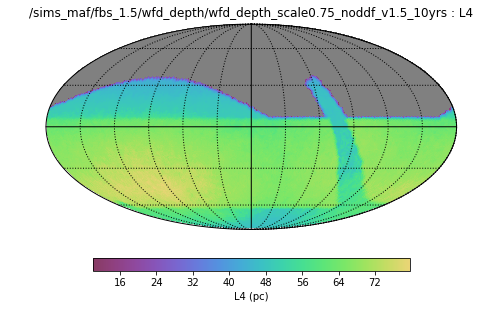

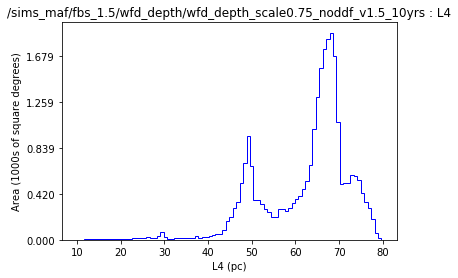

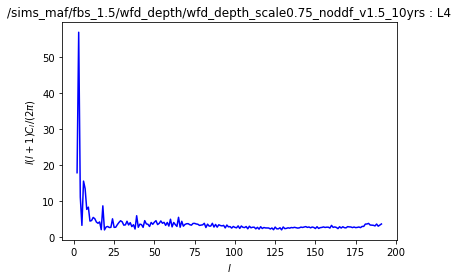

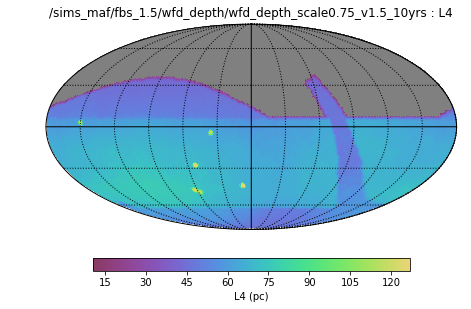

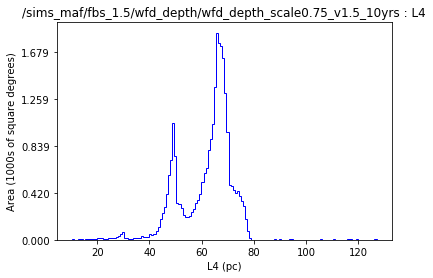

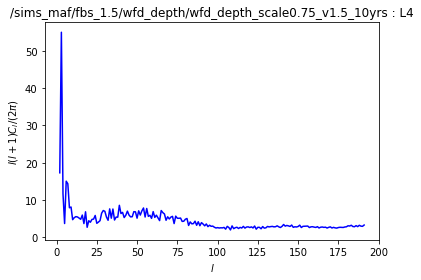

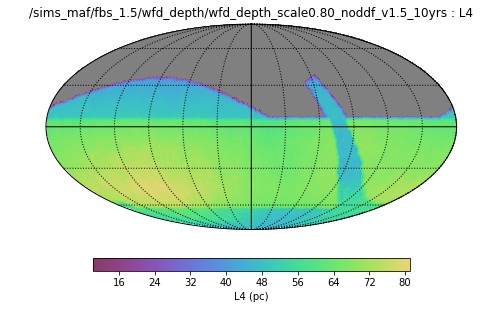

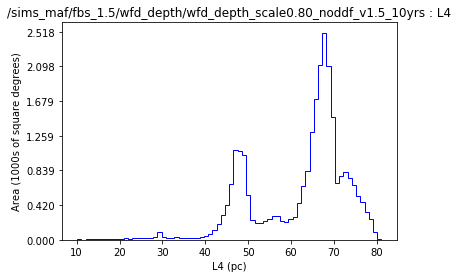

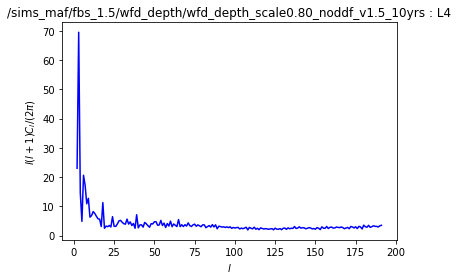

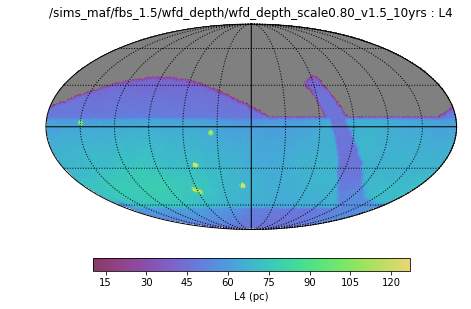

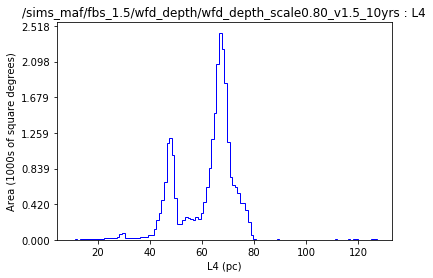

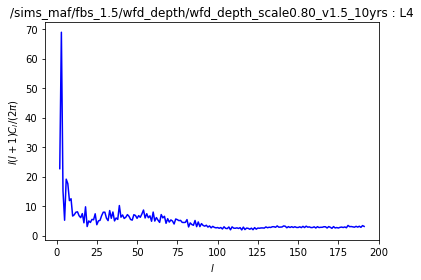

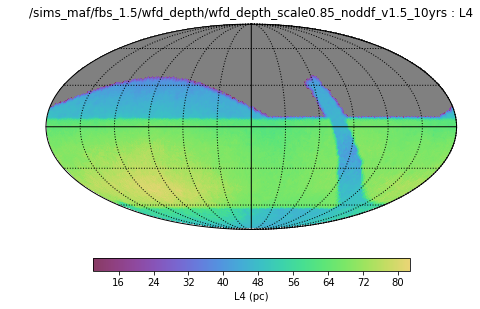

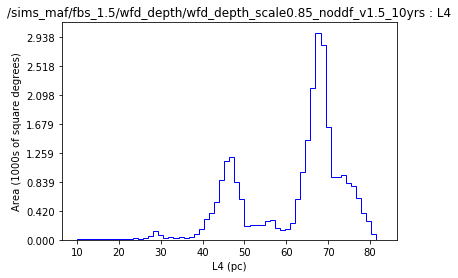

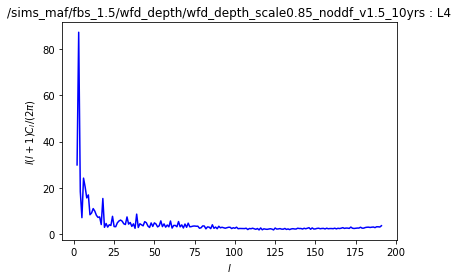

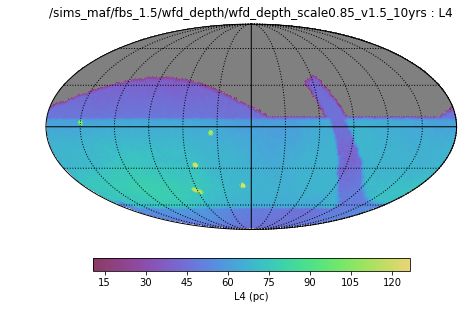

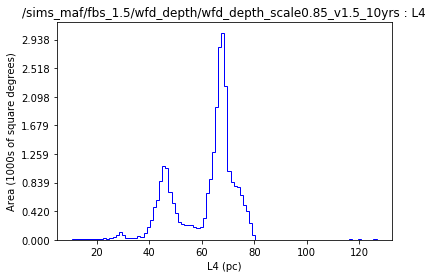

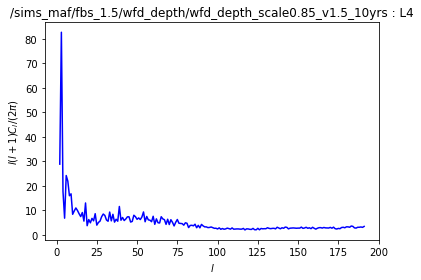

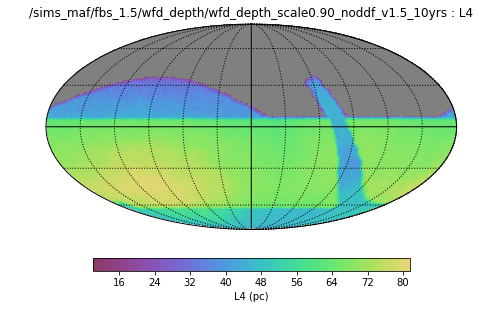

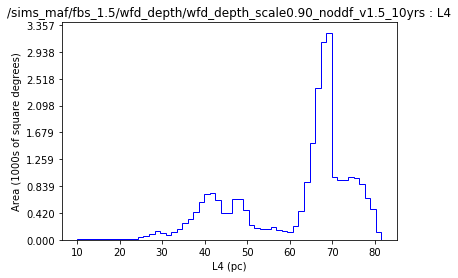

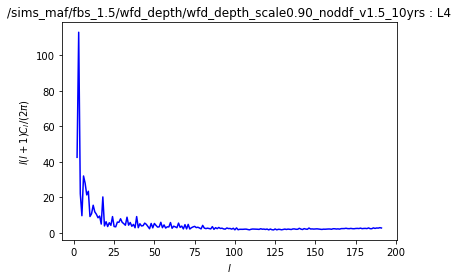

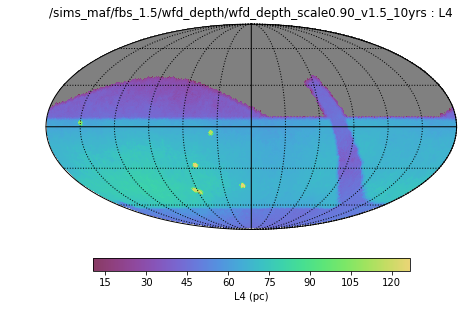

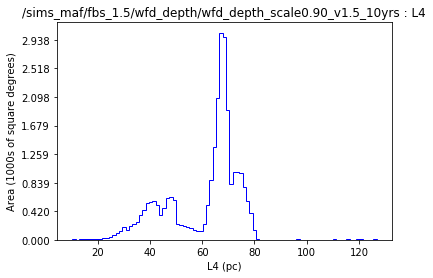

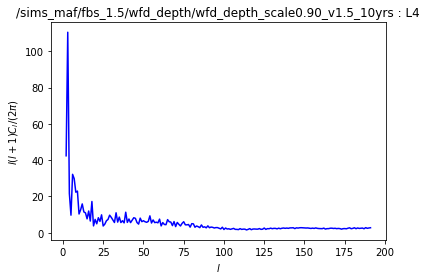

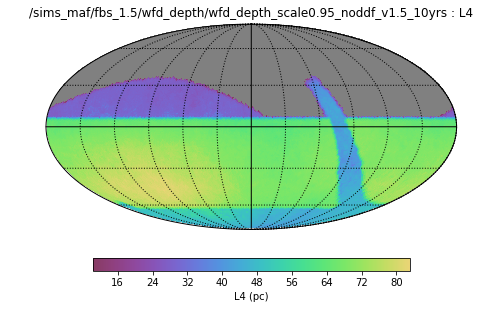

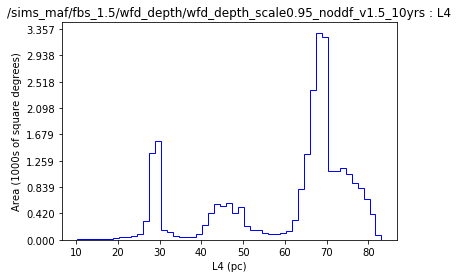

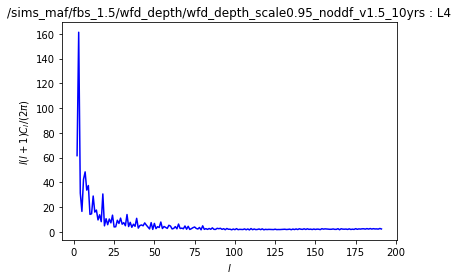

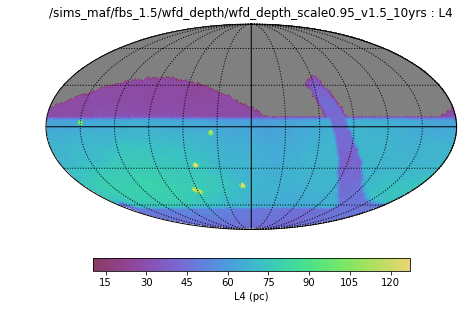

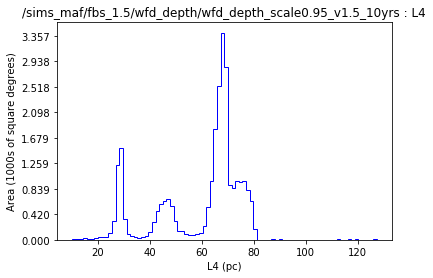

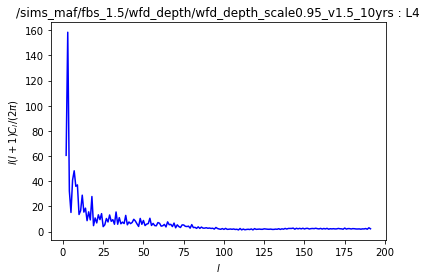

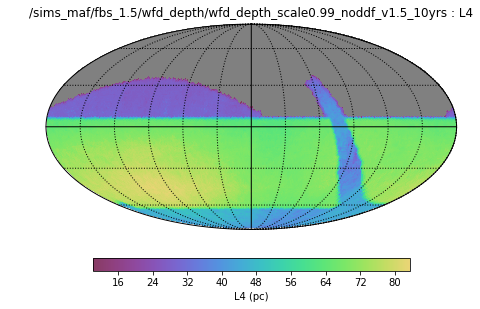

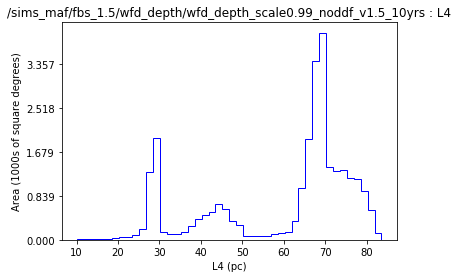

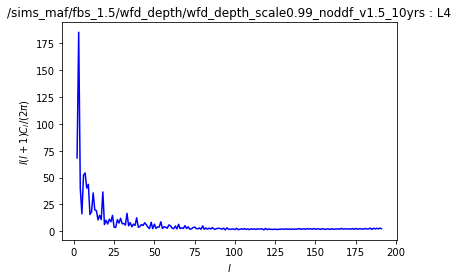

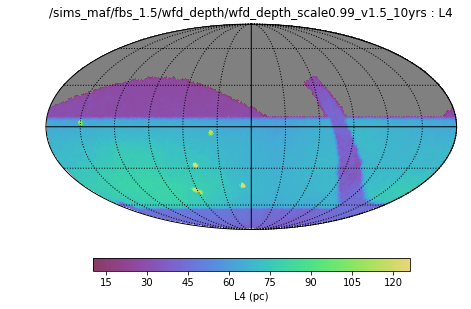

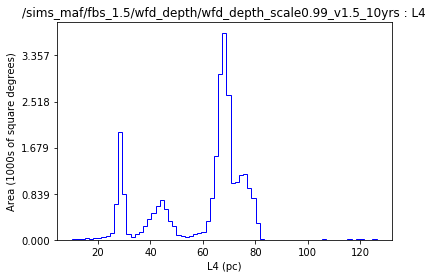

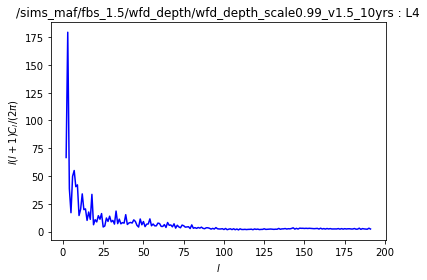

In [4]:
files = glob.glob('/sims_maf/fbs_1.5/[r-z]*/*.db')
files.sort()
results = []
for dbFile in files:
    
    runName = dbFile.replace('.db', '')
    conn = db.OpsimDatabase(dbFile)
    
    outDir = runName + '_bdvol'
    outDir=outDir.replace('/sims_maf/fbs_1.5/',"L4results/")
    resultsDb = db.ResultsDb(outDir=outDir)
    
    nside = 64
    bundleList = []
    #sql = 'filter="z" or filter="y"'
    sql = ''
    # Let's plug in the magnitudes for one type
    metric = BDParallaxMetric(mags={'i': 18.35, 'z': 16.68, 'y': 15.66}, metricName='L4')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [VolumeSumMetric(nside=nside)]
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=runName))
    # add DCR degeneracy check...
    #sql = 'filter="z" or filter="y"'
    #metric = metrics.ParallaxDcrDegenMetric(SedTemplate='M', rmag=20.)
    #bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
    #                                         runName=runName))
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    bg.plotAll(closefigs=False)

    results.append(bg)

In [5]:
# Let's see how the total volume changes as we change the footprint
for name, result in zip(files, results):
    key = list(result.bundleDict.keys())[0]
    result.bundleDict[key]
    print(name, result.bundleDict[key].summaryValues)

/sims_maf/fbs_1.5/rolling/rolling_mod2_sdf_0.10_v1.5_10yrs.db {'VolumeSum': 695109.2300435593}
/sims_maf/fbs_1.5/rolling/rolling_mod2_sdf_0.20_v1.5_10yrs.db {'VolumeSum': 691370.4251030023}
/sims_maf/fbs_1.5/rolling/rolling_mod3_sdf_0.10_v1.5_10yrs.db {'VolumeSum': 675574.0488026792}
/sims_maf/fbs_1.5/rolling/rolling_mod3_sdf_0.20_v1.5_10yrs.db {'VolumeSum': 676739.4962012963}
/sims_maf/fbs_1.5/rolling/rolling_mod6_sdf_0.10_v1.5_10yrs.db {'VolumeSum': 658381.4058550197}
/sims_maf/fbs_1.5/rolling/rolling_mod6_sdf_0.20_v1.5_10yrs.db {'VolumeSum': 662801.2579678975}
/sims_maf/fbs_1.5/same_filt/baseline_samefilt_v1.5_10yrs.db {'VolumeSum': 703338.6189769639}
/sims_maf/fbs_1.5/short_exp/short_exp_2ns_1expt_v1.5_10yrs.db {'VolumeSum': 714319.9141498575}
/sims_maf/fbs_1.5/short_exp/short_exp_2ns_5expt_v1.5_10yrs.db {'VolumeSum': 709697.429613653}
/sims_maf/fbs_1.5/short_exp/short_exp_5ns_1expt_v1.5_10yrs.db {'VolumeSum': 708465.5712110919}
/sims_maf/fbs_1.5/short_exp/short_exp_5ns_5expt_v1.5_

In [6]:
print('hi')




hi
